In [20]:
#helper libraries
import numpy as np
from numpy.random import rand
import math
import scipy.optimize
import matplotlib.pyplot as plt

#qiskit functionalities
from qiskit import Aer, execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram

#noise model stuff
from qiskit.providers.aer.noise import NoiseModel, kraus_error, pauli_error
    
#operator info
from qiskit.quantum_info import PauliList, Pauli, Kraus
from qiskit.circuit.library import XGate

#%load_ext autoreload
#%autoreload 2
import PauliExperimentHelperFunctions as pe

## Create noise model

I boiled all of the code for creating the error model and learning the error model into methods in `PauliNoiseModel.py` to make space for the new code. The original code can be found in `../NoiseModels/OneQubitPEC.ipynb`, the methods in the file are commented. The variable `noise_model` stores the Kraus map representing the channel generated by the Lindbladian $\mathcal L(\rho) = \sum_{k \in \mathcal{K}}\lambda_k(P_k\rho P_k-\rho)$, where $\lambda_k$ is input in the variable `coeffs`. The variable `basis_gates` stores the gates that the noise is applied to.

In [33]:
n = 1 #Number of qubits
F = PauliList(['I', 'X', 'Y', 'Z']) #list of paulis
T = PauliList(['X', 'Y', 'Z']) #paulis considered in the model
coeffs = [.01, .05, .0085] #model coefficients

#Kraus error channel
noise_model = pe.build_noise_model(F, T, coeffs, n)

/home/ben/.local/lib/python3.10/site-packages/qiskit/quantum_info/operators/channel/kraus.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if isinstance(data, np.ndarray) or np.array(data).ndim == 2:


## Learn the noise model

The fidelities are measured at different circuits depths up to `folds*2` with `gate` $\mathcal G$ by applying $(GG^{-1})^f$, where $f$ is the number of folds. 

In [3]:
backend = Aer.get_backend('qasm_simulator')
gate = XGate() #the gate to use for noise profiling
folds = 40 #number of folds to fit noise
shots = 4096 #number of shots for expectation values

In [4]:
#generate the circuits with increasing numbers of folds
circuits = pe.generate_circuits('X', gate, folds)
#extract expectation values at each circuit depth
xfidelities = pe.fidelity_experiment(circuits, backend, basis_gates, noise_model,shots)

#repeat for <Y>
circuits = pe.generate_circuits('Y', gate, folds)
yfidelities = pe.fidelity_experiment(circuits, backend, basis_gates, noise_model,shots)

#repeat for <Z>
circuits = pe.generate_circuits('Z', gate, folds)
zfidelities = pe.fidelity_experiment(circuits, backend, basis_gates, noise_model,shots)

## Plot the measurements

Since $\operatorname{Tr}[P_a\Lambda(I)]=0$, the exponential fit is parameterized as $ae^{-bx}$. Since noisy gates are used for preparation, $a$ accounts for SPAM. The fidelities are assumed to be $e^{-b}$, corresponding to half a fold.

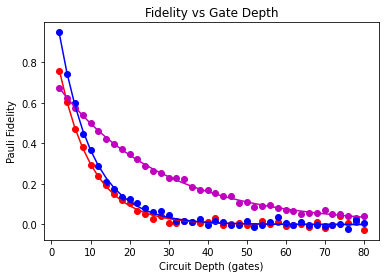

In [9]:
xrange = np.multiply(2,range(1,1+folds))

plt.plot(xrange, xfidelities, 'ro')
plt.plot(xrange, yfidelities, 'mo')
plt.plot(xrange, zfidelities, 'bo')

bx, ax = pe.get_exponential_fit(xfidelities)
plt.plot(xrange, ax*np.exp(np.multiply(-1*bx, xrange)), 'r')

by, ay = pe.get_exponential_fit(yfidelities)
plt.plot(xrange, ay*np.exp(np.multiply(-1*by, xrange)), 'm')

bz, az = pe.get_exponential_fit(zfidelities)
plt.plot(xrange, az*np.exp(np.multiply(-1*bz, xrange)), 'b');

plt.xlabel("Circuit Depth (gates)")
plt.ylabel("Pauli Fidelity")
plt.title("Fidelity vs Gate Depth");

## Find accuracy of learning

The least squares method is used to infer the model coefficients from the overdteremined system. The sum of the distances between the fidelities and the model coefficients are printed out to check that nothing went wrong.

In [11]:
#Use the coefficients from the fit to predict the model fidelities
measured_fidelities = pe.learn_fidelities(xfidelities, yfidelities, zfidelities)
#get the coefficients from the fit
measured_coeffs = pe.learn_model_coefficients(measured_fidelities, F, T)

def unzip(zippedlist):
    return [a for (x,a) in zippedlist]

def manhattannorm(a, b):
    return np.sum(np.abs(np.subtract(a,b)))

print("Manhattan distance between measured/ideal fidelity vectors: ", "%.5f" %manhattannorm(unzip(pe.get_ideal_fidelities(F, T, coeffs)), unzip(measured_fidelities)))
print("Manhattan distance between measured/ideal model coefficients: ", "%.5f" %manhattannorm(unzip(measured_coeffs), coeffs))

Manhattan distance between measured/ideal fidelity vectors:  0.00258
Manhattan distance between measured/ideal model coefficients:  0.00188


## Canonical Noise Scaling

Canonical noise scaling involves separating the distribution into the negative and positive volumes by the sign of the coefficients. Given a QPD representation of a unitary $\mathcal{U}$ in terms of noisy gates $\mathcal{O}_\alpha\in \mathcal{I}$,
$$
\mathcal{U} = \sum_{\alpha} \eta_\alpha \mathcal{O}_\alpha
$$
the indices $\alpha$ corresponding to negative and positive coefficients can be separated into two sets:
$$
D^{\pm} = \{\alpha \ | \ \eta_\alpha \gtrless 0\}
$$
Then the gates corresponding to each set can be used to construct a TPCP operator:
$$
\Phi^{\pm} = \frac{1}{\gamma^{\pm}}\sum_{\alpha \in D^{\pm}}|\eta_\alpha| \mathcal{O}_\alpha
$$
Where the overhead is selected so that the operator is trace-preserving:
$$
\gamma^{\pm} = \sum_{\alpha \in D^{\pm}}|\eta_\alpha|
$$
Then $\mathcal{U}$ can be written in terms of these channels:
$$
\mathcal{U} = \gamma^+ \Phi^+ - \gamma^- \Phi^-
$$
A noisy gate $\mathcal{U}^\lambda$ can be parameterized as
$$
\mathcal{U}^\lambda = (\gamma^+-\lambda \gamma^-)\Phi^+-(1-\lambda)\gamma^-\Phi^-
$$
This has the convenient property that at $\lambda = 0$ it reduces to the ideal QPD, at $\lambda = 1$ it reduces to $\Phi^+$ representing around hardware noise level, and at $\lambda = \frac{\gamma^+}{\gamma^-}$ it reduces to $\Phi^-$, representing the greatest level of noise.

## Separating negative and positive volumes

In the text, it is shown that taking $\mathcal{L} \to -\mathcal{L}$ leads to the inverse of the channel fidelities $f_a \to \frac{1}{f_a}$. Using the Walsh-Hadamard transform, these fidelities can be used to define a Pauli channel:
$$
\Lambda^{-1}(\rho) = \sum_{i} c_i P_i \rho P_i
$$
where the coefficient $c_i$ can be found with
$$
c_i = \sum_{j \in \mathcal{F}}(-1)^{\langle i, j \rangle_{sp}}\frac{1}{f_a}
$$
This leads to an unphysical inverse map where some of the eigenvalues are negative, which can be implemented as a QPD. I am not sure if the sampling remains efficient because the number of operators to sample now scales as $4^n$. I think this might make this method intractible, unless there is a more efficient way to get the positive and negative volumes.

In [52]:
#Invert the fidelities and transform to inverse process matrix
chi = []
for b in range(len(F)):
    chi.append(pe.WHtransform(b, np.divide(1, unzip(measured_fidelities)), F))
print("Chi matrix diagonal: ", chi)

Chi matrix diagonal:  [1.071817946673368, -0.009721956474072202, -0.0527204202174002, -0.00937556998189537]


Separate the volume into negative and positive, then form the TPCP channels by computing overheads and converting into QPD

In [53]:
Dplus = [i for (i, c) in enumerate(chi) if c > 0]
Dminus = [i for (i, c) in enumerate(chi) if c < 0]

gammaplus = np.sum([chi[i] for i in Dplus])
gammaminus = np.multiply(-1, np.sum([chi[i] for i in Dminus]))

#Transform the probabilities in chi into valid probability distribution
for alpha in Dplus:
    chi[alpha] /= gammaplus
for alpha in Dminus:
    chi[alpha] /= -gammaminus

print("Positive channel overhead: ", "%.3f" % gammaplus)
print("Negative channel overhead: ", "%.3f" % gammaminus)

Positive channel overhead:  1.072
Negative channel overhead:  0.072


In [112]:
samples = 1000 #number of samples from the distribution

Create circuit with a single layer of a one-qubit gate to measure the expectation value

In [113]:
ideal_circuit = QuantumCircuit(1,1)
ideal_circuit.x(0)

full_circuit = ideal_circuit.copy()#for displaying purposes
full_circuit.measure(0,0)

#get unmitigated value by taking the same number of samples of a noisy circuit
backend = Aer.get_backend("qasm_simulator")
job = execute(full_circuit, backend, noise_model = noise_model, basis_gates = basis_gates, shots = samples)
unmitigated_value = pe.expectation(job.result().get_counts())

ideal_circuit.barrier()
full_circuit.draw()

┌───┐┌─┐
  q: ┤ X ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0

Create a distribution of circuits in `circuits` such that the map
$$
(\gamma^+-\lambda \gamma^-)\Phi^+-(1-\lambda)\gamma^-\Phi^-
$$
is implemented. First, when $\lambda < 1$, the total overhead can be defined as
$$
\gamma_{tot} = \gamma - 2\lambda \gamma^-
$$
Where $\gamma = \gamma^++\gamma^-$ is the normal overhead. The protocol is the following:
1. Sample $\Phi^+$ with probability $\frac{\gamma^+-\lambda \gamma^-}{\gamma-2\lambda\gamma^-}$ and sample $\Phi^-$ otherwise
2. If from $\Phi^+$, then
    1. Sample from $\mathcal F$ (the set of Paulis) according to the subset $\chi_{D^+}$, which has been converted to a distribution
    2. Scale the result of running the circuit by $\gamma-2\lambda \gamma^-$
    3. Add to total result
3. If from $\Phi^{-}$ then
    1. Sample from $\mathcal F$ according to the subset $\chi_{D^-}$, which has been converted to a distribution
    2. Scale the result of the circuit by $-(\gamma-2\lambda \gamma^-)$,
    3. Add to the total result
4. Find the value of the estimator by dividing the total by the number of samples

In [128]:
#Sample from a distribution
def sample(dist):
    i = rand()
    intervals = np.cumsum(dist)
    return min(j for j,c in enumerate(intervals) if c > i)

def simulate_error_mitigation(starting_circuit, samples, 
                              Dplus, Dminus, chi, pplus, gammaplus, gammaminus, lmbda,
                              backend, noise_model):
    #check if lambda is within the allowed range
    if(lmbda > gammaplus/gammaminus):
        print("Lambda is above maximum noise")
        return
    
    if(lmbda < 1):
        gamma_tot = gammaplus+gammaminus-2*lmbda*gammaminus #factor if lambda < 1
    else:
        gamma_tot = 1 #factor if lambda > 1
        
    pplus = (gammaplus - lmbda*gammaminus)/gamma_tot #probability of choosing Phi^+
        
    circuits = []
    sgns = []
    
    for i in range(samples):
        circuit = ideal_circuit.copy() #start with ideal circuit
        op = F[0] #how do you initialize variables in python?
        
        if rand() < pplus: #sample Phi^+ or Phi^-
            op = F[Dplus[sample([chi[a] for a in Dplus])]] #sample from paulis
            sgns.append(1) #record the sign chosen for later
        else:
            op = F[Dminus[sample([chi[a] for a in Dminus])]] #sample from paulis
            sgns.append(-1) #record sign
            
        circuit.append(op.to_instruction(), [0]) #add op to circuit
        circuit.measure(0,0)
        circuits.append(circuit)
    
    #execute all circuits from the distribution with one shot apiece
    job = execute(circuits, backend, noise_model = noise_model, basis_gates = noise_model.basis_gates, shots = 1)
    counts = job.result().get_counts()
    
    #weight the individual measurements and average according to the procedure
    total = 0
    for (count, sign) in zip(job.result().get_counts(), sgns):
        total += pe.expectation(count)*gamma_tot*sign
        
    return (total / len(sgns), gamma_tot)

## Find estimator for different values of $\lambda$

In [143]:
lmbdas = [0, .2, .4, .6, .8, 1, 1.2]
mitigated_values = []
overheads = []
#Run the procedure for each lambda
for lmbda in lmbdas:
    mitigated_value, overhead = simulate_error_mitigation(ideal_circuit, samples, Dplus, Dminus, chi, pplus, gammaplus, gammaminus, lmbda, backend, noise_model)
    mitigated_values.append(mitigated_value)
    overheads.append(overhead) #overhead interpolates linearly between max overhead and 1

Maximum overhead:  1.14


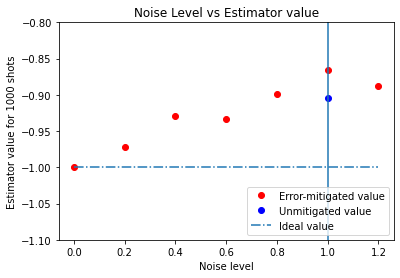

In [144]:
xrange = np.linspace(0, max(lmbdas), 100)
plt.ylim([-1.1, -.80])
mv, = plt.plot(lmbdas, mitigated_values, 'ro')
umv, = plt.plot(1.0, unmitigated_value, 'bo')
iv, = plt.plot(xrange, [-1]*len(xrange), '-.')
plt.xlabel("Noise level")
plt.ylabel("Estimator value for %s shots" %samples)
plt.axvline(1)
plt.title("Noise Level vs Estimator value")
plt.legend([mv, umv, iv], ['Error-mitigated value', 'Unmitigated value', 'Ideal value'], loc="lower right")
print("Maximum overhead: ", "%.2f" % overheads[0])